In [25]:
import logging
from typing import Callable, Literal, Optional, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize

from bwlogger import StyleAdapter
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional, Union, Any

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

from aamalha.utils.performance import Performance
from bwbbgdl import GoGet
from bwlogger import StyleAdapter, basic_setup
from bwutils import TODAY, Date

from utils import calculate_weights, get_available_trackers, load_trackers, correlation_to_distance
from plot import plot_results

In [23]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados")

# Load Data

### Bloomberg Data

In [2]:
path = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\Projeto Asset Allocation.xlsx"
df_base = pd.read_excel(path, index_col=0, skiprows=1, sheet_name="base_values")
df_base

,IDADDI Index,IDKAP3A Index,BZRFIMB5 Index,BZRFIB5+ Index,BCOMTR Index,IBOV Index,SPXT Index,UKXUSDT Index,HSI 1 Index,NIFTYTR Index,...,BZACCETP Index,G0O1 Index,LT09TRUU Index,B1MSBRUS Index,USDEUR Curncy,USDHKD Curncy,USDINR Curncy,USDCNY Curncy,USDJPY Curncy,USDBRL Curncy
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,139.9930,16930.42,2002.11,NaN,NaN,1688.44,...,5.042832,511.676,165.64,NaN,0.9763,7.7759,43.5300,8.2798,101.45,1.8190
2000-01-04,NaN,NaN,NaN,NaN,139.1780,15851.00,1925.41,NaN,NaN,1737.75,...,5.046277,511.814,166.44,NaN,0.9713,7.7775,43.5050,8.2799,103.22,1.8510
2000-01-05,NaN,NaN,NaN,NaN,138.4490,16245.14,1929.28,NaN,NaN,1692.25,...,5.049719,511.889,165.39,NaN,0.9689,7.7778,43.4900,8.2798,104.14,1.8390
2000-01-06,NaN,NaN,NaN,NaN,138.5270,16106.89,1931.51,NaN,NaN,1715.37,...,5.053163,512.037,165.89,NaN,0.9682,7.7778,43.5400,8.2797,105.23,1.8415
2000-01-07,NaN,NaN,NaN,NaN,138.1060,16309.15,1983.83,NaN,NaN,1710.81,...,5.056610,512.159,166.47,NaN,0.9713,7.7776,43.5500,8.2794,105.34,1.8270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,3645.809201,8601.439,9262.328,11124.580,241.9382,120445.91,11931.80,1890.58,61699.92,34873.15,...,81.385160,800.113,463.15,19.3716,0.9344,7.8044,83.6475,7.2604,158.93,5.4501
2024-06-21,3648.057215,8626.378,9275.547,11182.560,239.5644,121341.13,11913.78,1874.10,60667.52,34779.90,...,81.417120,800.472,463.15,19.4079,0.9352,7.8064,83.5400,7.2610,159.80,5.4320
2024-06-24,3649.638713,8646.920,9284.778,11190.810,241.6397,122636.96,11878.04,1893.03,60664.77,34834.33,...,81.449092,800.556,463.61,19.2372,0.9317,7.8079,83.4688,7.2594,159.62,5.3905


### Auxiliar Table

In [8]:
df_base_aux = pd.read_excel(path, index_col=0, usecols="A:E", sheet_name="aux")
df_base_aux

,field,alias,currency,include
ticker_bbg,,,,
IDADDI Index,LAST_PRICE,Debentures,BRL,True
IDKAP3A Index,LAST_PRICE,Pre-fixados,BRL,True
BZRFIMB5 Index,LAST_PRICE,Inflação (<5),BRL,True
BZRFIB5+ Index,LAST_PRICE,Inflação (>5),BRL,True
BCOMTR Index,TOT_RETURN_INDEX_GROSS_DVDS,Commodities,USD,True
IBOV Index,TOT_RETURN_INDEX_GROSS_DVDS,Ações Brasil,BRL,True
SPXT Index,TOT_RETURN_INDEX_GROSS_DVDS,S&P 500,USD,True
UKXUSDT Index,TOT_RETURN_INDEX_GROSS_DVDS,FTSE TR Index,USD,True
HSI 1 Index,TOT_RETURN_INDEX_GROSS_DVDS,HIS TR Index,HKD,True


### Trackers

In [14]:
df_trackers = df_base[df_base_aux[df_base_aux["include"]].index].rename(columns=df_base_aux["alias"]).copy()
df_trackers

,Debentures,Pre-fixados,Inflação (<5),Inflação (>5),Commodities,Ações Brasil,S&P 500,FTSE TR Index,HIS TR Index,NIFTY 50 TR Index,CSI 300 TR Index,EURO STOXX 50 TR Index,Nikkei TR Index,DAX Index,Treasury 20+ Y TR Index,HYG TR Index
Dates,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,139.9930,16930.42,2002.11,NaN,NaN,1688.44,NaN,NaN,NaN,6750.76,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,139.1780,15851.00,1925.41,NaN,NaN,1737.75,NaN,NaN,NaN,6586.95,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,138.4490,16245.14,1929.28,NaN,NaN,1692.25,NaN,NaN,NaN,6502.07,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,138.5270,16106.89,1931.51,NaN,NaN,1715.37,NaN,NaN,NaN,6474.92,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,138.1060,16309.15,1983.83,NaN,NaN,1710.81,NaN,NaN,NaN,6780.96,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,3645.809201,8601.439,9262.328,11124.580,241.9382,120445.91,11931.80,1890.58,61699.92,34873.15,4916.884,2326.07,68294.68,18254.18,195.8399,227.4354
2024-06-21,3648.057215,8626.378,9275.547,11182.560,239.5644,121341.13,11913.78,1874.10,60667.52,34779.90,4907.300,2310.02,68231.52,18163.52,195.8399,227.7003
2024-06-24,3649.638713,8646.920,9284.778,11190.810,241.6397,122636.96,11878.04,1893.03,60664.77,34834.33,4881.731,2324.66,68603.10,18325.58,196.6319,227.4649


In [21]:
output_data: list[tuple[pd.DataFrame, dict[str, Any]]] = []

## Analysis

### Performance Trackers

In [ ]:
perf_trackers = Performance(df_trackers)
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.to_excel(OUTPUT_FOLDER.joinpath("performance_trackers.xlsx"))

### Correlation

In [45]:
df_corr = np.log(df_trackers).diff(1).corr().copy()
df_corr.to_excel(OUTPUT_FOLDER.joinpath("full_sample_correlation.xlsx"))

### Dendogram

C:\Users\pcampos\AppData\Local\Temp\ipykernel_30312\2662915386.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)


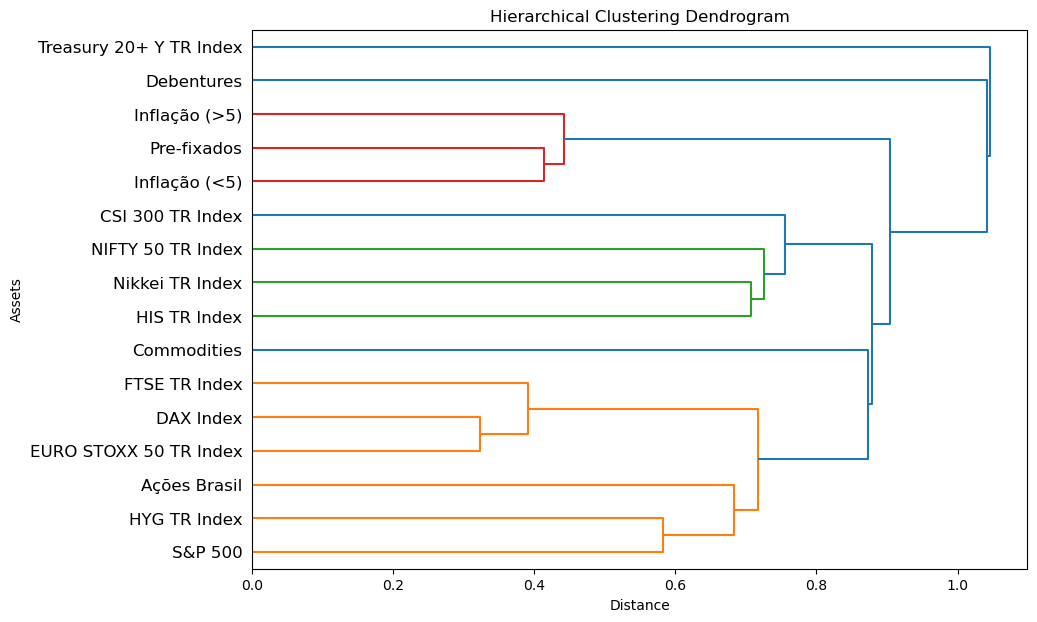

In [48]:
linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="right",  # Change orientation to 'left' to have labels on y-axis
    labels=df_corr.columns,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Assets")
plt.xlabel("Distance")
plt.savefig(OUTPUT_FOLDER.joinpath("dendrogram.svg"))
plt.show()

## Portfolio Construction